# t-SNE on Amazon Fine Food with color-coding

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

This reviews dataset contains:

No. of reviews: 568,454<br>
No. of users: 256,059<br>
No. of products: 74,258<br>
Year of data : upto Oct 2012<br>
No. of Attributes in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

### Objective
To find wheather the rating is positive or negative based on the rating given by the user.


In [2]:
#Importing all the necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# Connecting to the database
con = sqlite3.connect('./database.sqlite')

### Text Preprocessing
used the same as in your ipython notebook

In [6]:
filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
print("No. data points in our dataset", filtered_data.shape)
filtered_data.head()

No. data points in our dataset (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [10]:

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

#### Observation
It is observed that after dropping the duplicate entries of the data the remaining reviews left of 568,454 is 364173

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In the above step we are checking if the helpfulnessNumeerator is greater than helpfulnessDenominator, and if found the values are dropped resulting in the final shape of the dataset

In [12]:
print(final.shape)

#HNo of positive and negative reviews are present in our dataset
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Observation
After the first phase of preprocessing the final dataset contains 364171 values with 307061 as positive reviews and 57110 as negative reviews

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
%%time
# performing stemming, stopwords and lemmatization
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

Wall time: 191 ms


In [15]:
%%time
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

Wall time: 19min 35s


In [16]:
final['CleanedText']=final_string


In [17]:
import pickle
final['CleanedText'].to_pickle('amazon_food_reviews_preprocessed')

In [18]:
final['CleanedText'] = pd.read_pickle('amazon_food_reviews_preprocessed')

In [19]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [20]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [21]:
polarity = final['Score']
polarity.shape

(364171,)

#### Bag of Words
Considering cleaned text for calculating BoW and Tf-Idf

In [22]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)

In [23]:
print("the type of count vectorizer ",type(final_counts))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


In [24]:
print("the shape of out text BOW vectorizer ",final_counts.get_shape())

the shape of out text BOW vectorizer  (364171, 71624)


In [25]:
print("the no. of unique words ", final_counts.get_shape()[1])

the no. of unique words  71624


#### Observation
After calculating BoW the type of vector we got is sparse matrix with shape (364171, 71624) and number of unique words 71624 

##### Sampling from the given dataset as it requires a lot of RAM

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 71624)


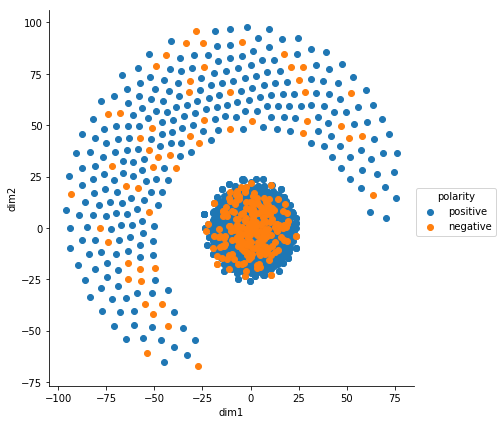

Wall time: 31min 5s


In [42]:
%%time
# TSNE
from sklearn.manifold import TSNE
import seaborn as sn

test_2000 = final_counts[:2000,:]
polarity_2000 = polarity[:2000]
bow_dense = test_2000.todense()

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(bow_dense)
print(standardized_data.shape)

model = TSNE(n_components=2, random_state=0, perplexity=50,n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_2000)).T
tsne_df = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])
tsne_df.to_pickle("./tsne_2000_50_2000")

tsne_df = pd.read_pickle("./tsne_2000_50_2000")
g = sns.FacetGrid(tsne_df, hue="polarity", size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()



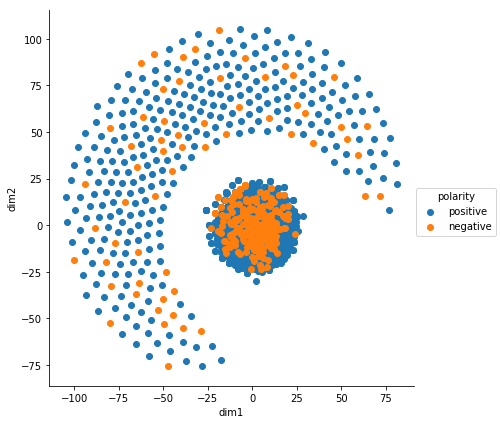

Wall time: 34min 17s


In [44]:
%%time
# With perplexity 30
model = TSNE(n_components=2, random_state=0, perplexity=30,n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_2000)).T
tsne_df = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])
tsne_df.to_pickle("./tsne_2000_50_2000")

tsne_df = pd.read_pickle("./tsne_2000_50_2000")
g = sns.FacetGrid(tsne_df, hue="polarity", size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()


#### Tf-idf

In [26]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [27]:
final_tf_idf

<364171x71624 sparse matrix of type '<class 'numpy.float64'>'
	with 11460537 stored elements in Compressed Sparse Row format>

In [28]:
test_2000 = final_tf_idf[:2000,:]
polarity_2000 = polarity[:2000]

In [29]:
test_2000.shape

(2000, 71624)

In [30]:
tfidf_dense = test_2000.todense()

In [31]:
%%time
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_dense)
print(standardized_data.shape)

(2000, 71624)
Wall time: 12.9 s


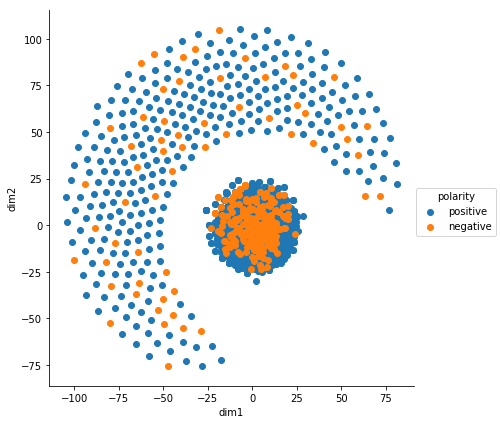

Wall time: 32min 21s


In [59]:
%%time
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter=1000)
tsne_data_tfidf = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T, polarity_2000)).T
tsne_df_tfidf = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])
tsne_df_tfidf.to_pickle('./tsne_tf_idf_2000_30_2000')
tsne_df_idf = pd.read_pickle('./tsne_tf_idf_2000_30_2000')

g = sns.FacetGrid(tsne_df_idf, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

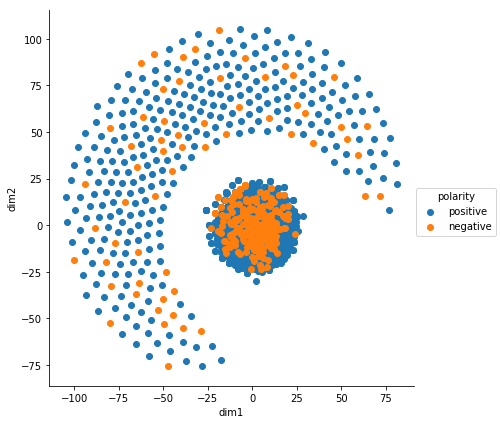

Wall time: 38min 5s


In [61]:
%%time
# with perplexity 50
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter=1000)
tsne_data_tfidf = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T, polarity_2000)).T
tsne_df_tfidf = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])
tsne_df_tfidf.to_pickle('./tsne_tf_idf_2000_50_2000')
tsne_df_idf = pd.read_pickle('./tsne_tf_idf_2000_50_2000')

g = sns.FacetGrid(tsne_df_idf, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

#### Avg Word2Vec

In [32]:
%%time
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    #ent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

Wall time: 3min 25s


In [33]:
%%time
w2v_model=gensim.models.Word2Vec(list_of_sent, min_count=5, size=50, workers=4)

Wall time: 1min 48s


In [38]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:20])

number of words that occured minimum 5 times  33457
sample words  ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along']


In [39]:
w2v_model.wv.most_similar('women')

[('patients', 0.8423488736152649),
 ('athletes', 0.8397140502929688),
 ('individuals', 0.7925033569335938),
 ('men', 0.7659471035003662),
 ('infants', 0.75042325258255),
 ('doctors', 0.7473247051239014),
 ('nurses', 0.7392463088035583),
 ('lactation', 0.7238891124725342),
 ('medical', 0.7221317291259766),
 ('physician', 0.7215472459793091)]

In [40]:
w2v_model.wv.most_similar('car')

[('backpack', 0.9095954895019531),
 ('purse', 0.9057983160018921),
 ('desk', 0.8609399199485779),
 ('briefcase', 0.854759156703949),
 ('pocket', 0.830160915851593),
 ('stroller', 0.8126643896102905),
 ('handbag', 0.8088341951370239),
 ('lunchbox', 0.7967369556427002),
 ('gym', 0.7777665853500366),
 ('hiking', 0.7722041010856628)]

In [34]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████| 364171/364171 [09:36<00:00, 631.44it/s]


364171
50


In [35]:
polarity = final['Score']
polarity.shape

(364171,)

In [61]:
test_100 = np.array(sent_vectors[:100],dtype='float64')
polarity_100 = polarity[:100]

In [62]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(test_100)
print(standardized_data.shape)

(100, 50)


Using more than 100 is returning NaN, or too large error

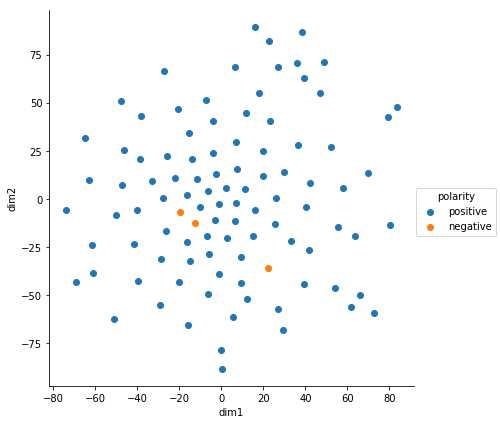

Wall time: 5.79 s


In [69]:
#
%%time
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_100)).T
tsne_df = pd.DataFrame(tsne_final,columns=['dim1','dim2','polarity'])
tsne_df.to_pickle('./tsne_avg_w2v_100_30_100')
tsne_df = pd.read_pickle('tsne_avg_w2v_100_30_100')

g= sns.FacetGrid(tsne_df, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

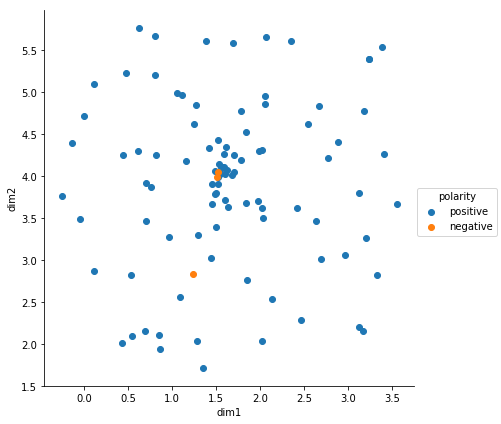

Wall time: 6.12 s


In [71]:
%%time
# With perplexity 50
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_100)).T
tsne_df = pd.DataFrame(tsne_final,columns=['dim1','dim2','polarity'])
tsne_df.to_pickle('./tsne_avg_w2v_100_50_100')
tsne_df = pd.read_pickle('tsne_avg_w2v_100_50_100')

g= sns.FacetGrid(tsne_df, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

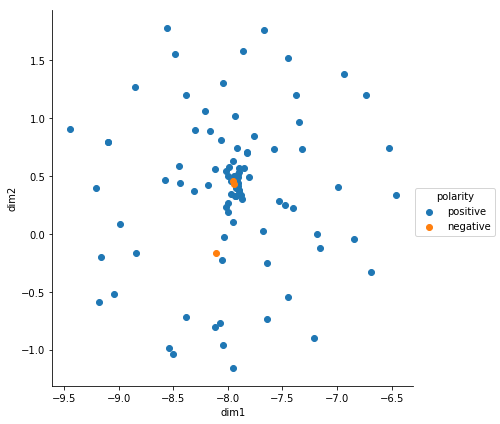

Wall time: 5.53 s


In [72]:
%%time
# With perplexity 70
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_100)).T
tsne_df = pd.DataFrame(tsne_final,columns=['dim1','dim2','polarity'])
tsne_df.to_pickle('./tsne_avg_w2v_100_70_100')
tsne_df = pd.read_pickle('tsne_avg_w2v_100_70_100')

g= sns.FacetGrid(tsne_df, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

#### Tf-Idf W2V

We will be using about w2v model. Taking 10k samples

In [83]:
list_of_sent_100 = list_of_sent[:100]

In [84]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_100: # for each review/sentence
    #print(row)
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
           # print("1. {}".format(word))
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #print(vec * 2)
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            #print(vec * tfidf)
            sent_vec += (vec * tfidf)
           # print(sent_vec)
            #print(tfidf)
            weight_sum += tfidf
            #print(weight_sum)
        except:
            pass
    
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

Wall time: 53.1 s


In [85]:
polarity = final['Score']
polarity.shape

(364171,)

In [86]:
polarity_100 = polarity[:100]

In [87]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(100, 50)


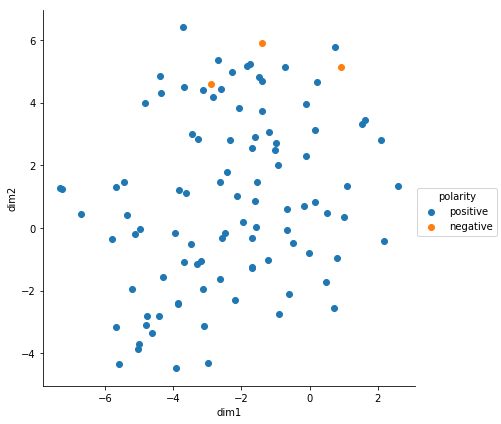

Wall time: 6.06 s


In [88]:
%%time
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_100)).T
tsne_df = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])

tsne_df.to_pickle('./tsne_tfidf_w2v_100_30_100')
tsne_df = pd.read_pickle('tsne_tfidf_w2v_100_30_100')

g = sns.FacetGrid(tsne_df, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

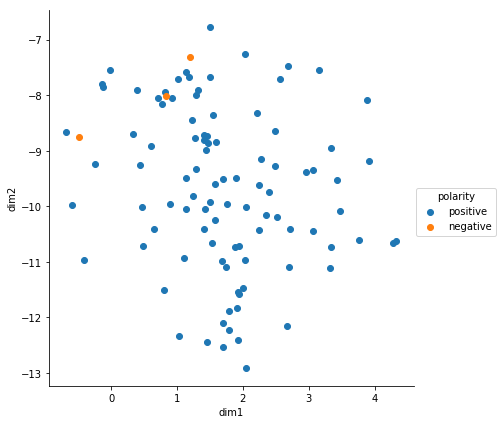

Wall time: 5.74 s


In [89]:
%%time
# with perplexity 50
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)

tsne_final = np.vstack((tsne_data.T,polarity_100)).T
tsne_df = pd.DataFrame(tsne_final, columns=['dim1','dim2','polarity'])

tsne_df.to_pickle('./tsne_tfidf_w2v_100_30_100')
tsne_df = pd.read_pickle('tsne_tfidf_w2v_100_30_100')

g = sns.FacetGrid(tsne_df, hue='polarity',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

Couldn't Work with more points as it's taking lot of time also giving errors.